<a href="https://colab.research.google.com/github/Young-Dong/nlp/blob/main/nlp100_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split


with zipfile.ZipFile('NewsAggregatorDataset.zip') as f:
    f.extractall('data')

df = pd.read_csv('data/newsCorpora.csv', sep='\t'
   ,header=None, names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])
target = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df_target = df[df['PUBLISHER'].isin(target)]

--2022-01-27 11:07:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  33.6MB/s    in 0.8s    

2022-01-27 11:07:14 (33.6 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [ ]:
df_target.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
12,13,Europe reaches crunch point on banking union,http://in.reuters.com/article/2014/03/10/eu-ba...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501755
13,14,ECB FOCUS-Stronger euro drowns out ECB's messa...,http://in.reuters.com/article/2014/03/10/ecb-p...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501948
19,20,"Euro Anxieties Wane as Bunds Top Treasuries, S...",http://www.businessweek.com/news/2014-03-10/ge...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503148
20,21,Noyer Says Strong Euro Creates Unwarranted Eco...,http://www.businessweek.com/news/2014-03-10/no...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503366
29,30,REFILE-Bad loan triggers key feature in ECB ba...,http://in.reuters.com/article/2014/03/10/euroz...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470505070


**70. 単語ベクトルの和による特徴量**

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$x_i$を並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

> $
X=
\left(
\begin{array}{c} 
    x_1\\ x_2\\ ...\\ x_n\\
\end{array}
\right)
∈R^{n×d},
Y=
\left(
\begin{array}{c} 
    y_1\\ y_2\\ ...\\ y_n\\
\end{array}
\right)
∈N^{n}
$

ここで，nは学習データの事例数であり，$x_i$∈$R^d$と$y_i$∈Nはそれぞれ，i∈{1,…,n}番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．N<4で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベル$y_i$は$y_i$∈N<4で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4である）．

i番目の事例の特徴ベクトル$x_i$は，次式で求める．

> $x_i=\frac{1}{T_i}∑_{t=1}^{T_i}emb(w_i,t)$

ここで，i番目の事例は$T_i$個の（記事見出しの）単語列($w_{i,1},w_{i,2},…,w_{i,Ti}$)から構成され，emb(w)∈$R^d$は単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$x_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300である．

i番目の事例のラベル$y_i$は，次のように定義する．

> $
y_i=\begin{cases}
  {0 (記事x_iが「ビジネス」カテゴリの場合)\\
  1 (記事x_iが「科学技術」カテゴリの場合)\\
  2 (記事x_iが「エンターテイメント」カテゴリの場合)\\
  3 (記事x_iが「健康」カテゴリの場合)}
\end{cases}
$

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

・学習データの特徴量行列: $X_{train}∈R^{Nt×d}$

・学習データのラベルベクトル: $Y_{train}∈N^{Nt}$

・検証データの特徴量行列: $X_{valid}∈R^{Nv×d}$

・検証データのラベルベクトル: $Y_{valid}∈N^{Nv}$

・評価データの特徴量行列: $X_{test}∈R^{Ne×d}$

・評価データのラベルベクトル: $Y_{test}∈N^{Ne}$

なお，$N_t,N_v,N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [ ]:
train, non_train = train_test_split(df_target, test_size=0.2, random_state=42)
valid, test = train_test_split(non_train, test_size=0.5, random_state=42)

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec

# official document https://radimrehurek.com/gensim/auto_examples/index.html#documentation

data = '/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(data, binary=True)

In [ ]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [ ]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[ 0.0892, -0.0251, -0.0682,  ..., -0.0559, -0.0038, -0.0919],
        [ 0.0538,  0.0353,  0.0121,  ...,  0.1317,  0.2012,  0.0249],
        [ 0.1075,  0.0263, -0.0342,  ...,  0.0381,  0.0845,  0.0992],
        ...,
        [ 0.0018,  0.0506,  0.0403,  ..., -0.0771,  0.0192, -0.0621],
        [-0.0252,  0.0566, -0.0808,  ...,  0.0292,  0.0887,  0.0360],
        [-0.0016,  0.1155, -0.0469,  ...,  0.0594, -0.0317, -0.1071]])


In [ ]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.LongTensor([category_dict[x] for x in train['CATEGORY']])
y_valid = torch.LongTensor([category_dict[x] for x in valid['CATEGORY']])
y_test = torch.LongTensor([category_dict[x] for x in test['CATEGORY']])

print(y_train.size())
print(y_train)

torch.Size([10672])
tensor([0, 3, 2,  ..., 2, 0, 0])


In [ ]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

**71. 単層ニューラルネットワークによる予測**

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$y_1=softmax(x_1W),Y=softmax(X_{[1:4]}W)$

ただし，softmaxはソフトマックス関数，X[1:4]∈R4×dは特徴ベクトルx1,x2,x3,x4を縦に並べた行列である．



> $
X_{[1:4]}=
\left(
\begin{array}{c} 
    x_1\\ x_2\\ x_3\\ x_4\\
\end{array}
\right)
$

行列$W∈R^{d×L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$y_1∈R^L$は未学習の行列Wで事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，$Y∈R^{n×L}$は，学習データの事例$x_1,x_2,x_3,x_4$について，各カテゴリに属する確率を行列として表現している．

In [ ]:
import torch.nn as nn

m = nn.Linear(300, 4)

In [ ]:
m.forward(X_train)

tensor([[-0.0866,  0.0092,  0.0851,  0.0258],
        [-0.0129, -0.0249,  0.1280,  0.0317],
        [-0.0566,  0.0274,  0.0046,  0.0176],
        ...,
        [-0.0281, -0.0380,  0.0823,  0.0281],
        [-0.0335, -0.0066,  0.1265,  0.0348],
        [-0.0622,  0.0037,  0.0909,  0.1341]], grad_fn=<AddmmBackward0>)

In [ ]:
y_pred = torch.softmax(m.forward(X_train[:4]), dim=1)
y_pred

tensor([[0.7322, 0.0242, 0.2265, 0.0171],
        [0.2979, 0.0383, 0.6327, 0.0312],
        [0.2879, 0.0461, 0.6345, 0.0314],
        [0.4471, 0.0289, 0.5040, 0.0200]], grad_fn=<SoftmaxBackward0>)

**72. 損失と勾配の計算**

学習データの事例$x_1$と事例集合$x_1,x_2,x_3,x_4$に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例$x_i$に対して損失は次式で計算される．

> $l_i=−log[事例x_iがy_iに分類される確率]$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
l1 = loss(m(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
# m.zero_grad()  # 勾配をゼロで初期化
l1.backward()  # 勾配を計算
print(f'損失: {l1:.4f}')
print(f'勾配: {m.weight.grad}')

損失: 1.3754
勾配: tensor([[-0.0642,  0.0151,  0.0538,  ...,  0.0326, -0.0082,  0.0798],
        [ 0.0225, -0.0022, -0.0217,  ..., -0.0133,  0.0069, -0.0223],
        [ 0.0168, -0.0121, -0.0093,  ..., -0.0043, -0.0042, -0.0323],
        [ 0.0249, -0.0008, -0.0229,  ..., -0.0150,  0.0054, -0.0252]])


**73. 確率的勾配降下法による学習**

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [ ]:
optimizer = torch.optim.SGD(m.parameters(), lr=0.1)

num_epochs = 100
for epoch in range(num_epochs):
  m.train()

  y_train_pred = torch.softmax(m.forward(X_train), dim=1)
  y_valid_pred = torch.softmax(m.forward(X_valid), dim=1)

  loss_train = loss(y_train_pred, y_train)
  loss_valid = loss(y_valid_pred, y_valid)

  loss_train.backward()
  optimizer.step()
  optimizer.zero_grad()

  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 1.0634, loss_valid: 1.0782
epoch: 2, loss_train: 1.0632, loss_valid: 1.0781
epoch: 3, loss_train: 1.0630, loss_valid: 1.0779
epoch: 4, loss_train: 1.0629, loss_valid: 1.0778
epoch: 5, loss_train: 1.0627, loss_valid: 1.0776
epoch: 6, loss_train: 1.0625, loss_valid: 1.0774
epoch: 7, loss_train: 1.0624, loss_valid: 1.0773
epoch: 8, loss_train: 1.0622, loss_valid: 1.0771
epoch: 9, loss_train: 1.0621, loss_valid: 1.0770
epoch: 10, loss_train: 1.0619, loss_valid: 1.0768
epoch: 11, loss_train: 1.0617, loss_valid: 1.0767
epoch: 12, loss_train: 1.0616, loss_valid: 1.0765
epoch: 13, loss_train: 1.0614, loss_valid: 1.0764
epoch: 14, loss_train: 1.0613, loss_valid: 1.0762
epoch: 15, loss_train: 1.0611, loss_valid: 1.0761
epoch: 16, loss_train: 1.0610, loss_valid: 1.0759
epoch: 17, loss_train: 1.0608, loss_valid: 1.0758
epoch: 18, loss_train: 1.0607, loss_valid: 1.0756
epoch: 19, loss_train: 1.0605, loss_valid: 1.0755
epoch: 20, loss_train: 1.0604, loss_valid: 1.0753
epoch: 21

**74. 正解率の計測**

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [ ]:
def acc(pred, y):
  pred = torch.max(pred.data,1)[1]
  return (pred == y).sum().item() / len(y)

In [ ]:
# 正解率の確認
acc_train = acc(y_train_pred, y_train)
acc_valid = acc(y_valid_pred, y_valid)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_valid:.3f}')

正解率（学習データ）：0.782
正解率（評価データ）：0.763


**75. 損失と正解率のプロット**

問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [ ]:
optimizer = torch.optim.SGD(m.parameters(), lr=0.1)

num_epochs = 100
log_train = []
log_valid = []
for epoch in range(num_epochs):
  m.train()

  y_train_pred = torch.softmax(m.forward(X_train), dim=1)
  y_valid_pred = torch.softmax(m.forward(X_valid), dim=1)

  loss_train = loss(y_train_pred, y_train)
  loss_valid = loss(y_valid_pred, y_valid)

  loss_train.backward()
  optimizer.step()
  optimizer.zero_grad()

  # 正解率の算出
  acc_train = acc(y_train_pred, y_train)
  acc_valid = acc(y_valid_pred, y_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 1.0305, accuracy_train: 0.7823, loss_valid: 1.0465, accuracy_valid: 0.7639
epoch: 2, loss_train: 1.0304, accuracy_train: 0.7823, loss_valid: 1.0465, accuracy_valid: 0.7639
epoch: 3, loss_train: 1.0303, accuracy_train: 0.7823, loss_valid: 1.0464, accuracy_valid: 0.7639
epoch: 4, loss_train: 1.0302, accuracy_train: 0.7823, loss_valid: 1.0463, accuracy_valid: 0.7639
epoch: 5, loss_train: 1.0302, accuracy_train: 0.7823, loss_valid: 1.0462, accuracy_valid: 0.7639
epoch: 6, loss_train: 1.0301, accuracy_train: 0.7823, loss_valid: 1.0462, accuracy_valid: 0.7639
epoch: 7, loss_train: 1.0300, accuracy_train: 0.7823, loss_valid: 1.0461, accuracy_valid: 0.7639
epoch: 8, loss_train: 1.0299, accuracy_train: 0.7823, loss_valid: 1.0460, accuracy_valid: 0.7639
epoch: 9, loss_train: 1.0299, accuracy_train: 0.7823, loss_valid: 1.0460, accuracy_valid: 0.7639
epoch: 10, loss_train: 1.0298, accuracy_train: 0.7823, loss_valid: 1.0459, accuracy_valid: 0.7639
epoch: 11, loss_train: 1.0297

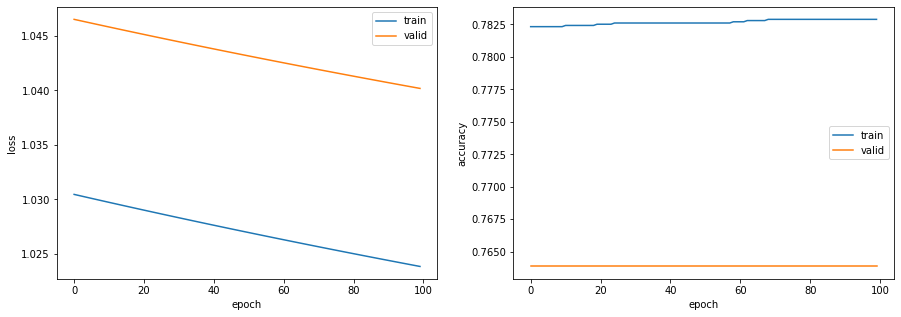

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# 可視化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

**76. チェックポイント**

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

**77. ミニバッチ化**

問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

**78. GPU上での学習**

問題77のコードを改変し，GPU上で学習を実行せよ．

**79. 多層ニューラルネットワーク**

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．